## Uczenie maszynowe UMZ 2018/2019
# 7a. Miary jakości

In [5]:
# Przydatne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas
import random
import seaborn

%matplotlib inline

In [6]:
# Wczytanie danych (gatunki kosaćców)

data_iris = pandas.read_csv('iris.csv', header=0, usecols=['łod.dł.', 'łod.sz.', 'pł.dł.', 'pł.sz.'])
data_iris.columns=['x1', 'x2', 'x3', 'x4']

X = data_iris.values
Xs = data_iris.values[:, 2:4]

In [7]:
# Wykres danych
def plot_unlabeled_data(X, col1=0, col2=1, x1label=r'$x_1$', x2label=r'$x_2$'):    
    fig = plt.figure(figsize=(16*.7, 9*.7))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    X1 = X[:, col1].tolist()
    X2 = X[:, col2].tolist()
    ax.scatter(X1, X2, c='k', marker='o', s=50, label='Dane')
    ax.set_xlabel(x1label)
    ax.set_ylabel(x2label)
    ax.margins(.05, .05)
    return fig

In [8]:
# Przygotowanie interaktywnego wykresu

dropdown_arg1 = widgets.Dropdown(options=[0, 1, 2, 3], value=2, description='arg1')
dropdown_arg2 = widgets.Dropdown(options=[0, 1, 2, 3], value=3, description='arg2')

def interactive_unlabeled_data(arg1, arg2):
    fig = plot_unlabeled_data(
        X, col1=arg1, col2=arg2, x1label='$x_{}$'.format(arg1), x2label='$x_{}$'.format(arg2))

In [9]:
widgets.interact(interactive_unlabeled_data, arg1=dropdown_arg1, arg2=dropdown_arg2)

interactive(children=(Dropdown(description=u'arg1', index=2, options=(0, 1, 2, 3), value=2), Dropdown(description=u'arg2', index=3, options=(0, 1, 2, 3), value=3), Output()), _dom_classes=('widget-interact',))

<function __main__.interactive_unlabeled_data>

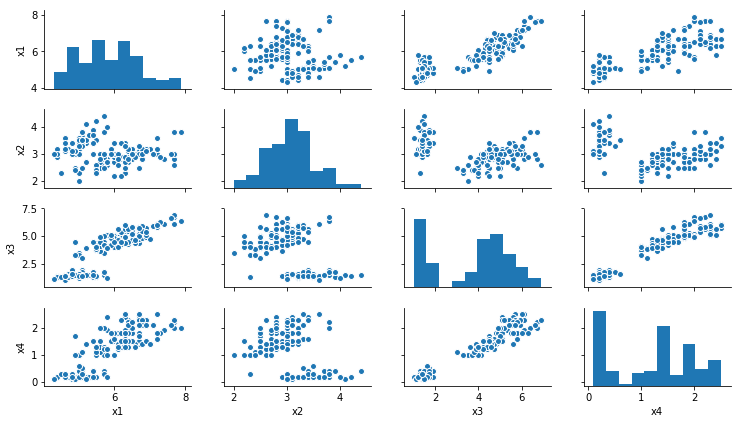

In [10]:
seaborn.pairplot(data_iris, vars=data_iris.columns, size=1.5, aspect=1.75)

In [11]:
# Odległość euklidesowa
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

In [12]:
# Algorytm k średnich
def k_means(X, k, distance=euclidean_distance):
    history = []
    Y = []
 
    # Wylosuj centroid dla każdej klasy
    centroids = [[random.uniform(X.min(axis=0)[f], X.max(axis=0)[f])
                     for f in range(X.shape[1])]
                 for c in range(k)]

    # Powtarzaj, dopóki klasy się zmieniają
    while True:
        distances = [[distance(centroids[c], x) for c in range(k)] for x in X]
        Y_new = [d.index(min(d)) for d in distances]
        if Y_new == Y:
            break
        Y = Y_new
        XY = np.asarray(np.concatenate((X, np.matrix(Y).T), axis=1))
        Xc = [XY[XY[:, 2] == c][:, :-1] for c in range(k)]
        centroids = [[Xc[c].mean(axis=0)[f] for f in range(X.shape[1])]
                     for c in range(k)]
        history.append((centroids, Y))

    result = history[-1][1]
    return result, history

In [13]:
# Wykres danych - klastrowanie
def plot_clusters(X, Y, k, centroids=None):
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig = plt.figure(figsize=(16*.7, 9*.7))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

    X1 = X[:, 0].tolist()
    X2 = X[:, 1].tolist()
    X1 = [[x for x, y in zip(X1, Y) if y == c] for c in range(k)]
    X2 = [[x for x, y in zip(X2, Y) if y == c] for c in range(k)]

    for c in range(k):
        ax.scatter(X1[c], X2[c], c=color[c], marker='o', s=25, label='Dane')
        if centroids:
            ax.scatter([centroids[c][0]], [centroids[c][1]], c=color[c], marker='+', s=500, label='Centroid')

    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.margins(.05, .05)
    return fig

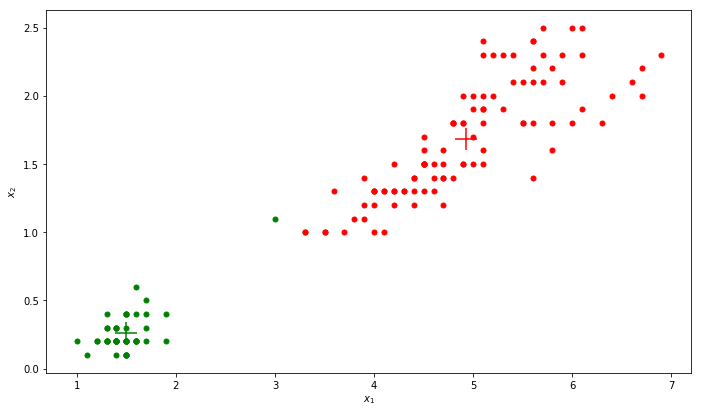

In [14]:
Ys, history = k_means(Xs, 2)
fig = plot_clusters(Xs, Ys, 2, centroids=history[-1][0])

In [15]:
# Przygotowanie interaktywnego wykresu

slider_k = widgets.IntSlider(min=1, max=7, step=1, value=2, description=r'$k$', width=300)

def interactive_kmeans_k(steps, history, k):
    if steps >= len(history) or steps == 10:
        steps = len(history) - 1
    fig = plot_clusters(Xs, history[steps][1], k, centroids=history[steps][0])
    
def interactive_kmeans(k):
    slider_steps = widgets.IntSlider(min=1, max=10, step=1, value=1, description=r'steps', width=300)
    _, history = k_means(Xs, k)
    widgets.interact(interactive_kmeans_k, steps=slider_steps,
                     history=widgets.fixed(history), k=widgets.fixed(k))

In [16]:
widgets.interact_manual(interactive_kmeans, k=slider_k)

interactive(children=(IntSlider(value=2, description=u'$k$', max=7, min=1), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.interactive_kmeans>

### Algorytm $k$ średnich – dane wejściowe

* $k$ – liczba klastrów
* zbiór uczący $X = \{ x^{(1)}, x^{(2)}, \ldots, x^{(m)} \}$, $x^{(i)} \in \mathbb{R}^n$

Na wejściu nie ma zbioru $Y$, ponieważ jest to uczenie nienadzorowane!

### Algorytm $k$ średnich – pseudokod

1. Zainicjalizuj losowo $k$ centroidów (środków ciężkości klastrów): $\mu_1, \ldots, \mu_k$.
1. Powtarzaj dopóki przyporządkowania klastrów się zmieniają:
   1. Dla $i = 1$ do $m$:
      za $y^{(i)}$ przyjmij klasę najbliższego centroidu.
   1. Dla $c = 1$ do $k$:
      za $\mu_c$ przyjmij średnią wszystkich punktów $x^{(i)}$ takich, że $y^{(i)} = c$.

In [17]:
# Algorytm k średnich
def k_means(X, k, distance=euclidean_distance):
    Y = []
    centroids = [[random.uniform(X.min(axis=0)[f],X.max(axis=0)[f])
                     for f in range(X.shape[1])]
                 for c in range(k)]  # Wylosuj centroidy
    while True:
        distances = [[distance(centroids[c], x) for c in range(k)]
                     for x in X]  # Oblicz odległości
        Y_new = [d.index(min(d)) for d in distances]
        if Y_new == Y:
            break  # Jeśli nic się nie zmienia, przerwij
        Y = Y_new
        XY = np.asarray(np.concatenate((X,np.matrix(Y).T),axis=1))
        Xc = [XY[XY[:, 2] == c][:, :-1] for c in range(k)]
        centroids = [[Xc[c].mean(axis=0)[f]
                      for f in range(X.shape[1])]
                     for c in range(k)]  # Przesuń centroidy
    return Y

* Liczba klastrów jest określona z góry i wynosi $k$.

* Jeżeli w którymś kroku algorytmu jedna z klas nie zostanie przyporządkowana żadnemu z przykładów, pomija się ją – w ten sposób wynikiem działania algorytmu może być mniej niż $k$ klastrów.

### Funkcja kosztu dla problemu klastrowania

$$ J \left( y^{(i)}, \ldots, y^{(m)}, \mu_{1}, \ldots, \mu_{k} \right) = \frac{1}{m} \sum_{i=1}^{m} || x^{(i)} - \mu_{y^{(i)}} || ^2 $$

* Zauważmy, że z każdym krokiem algorytmu $k$ średnich koszt się zmniejsza (lub ewentualnie pozostaje taki sam).

### Wielokrotna inicjalizacja

* Algorytm $k$ średnich zawsze znajdzie lokalne minimum funkcji kosztu $J$, ale nie zawsze będzie to globalne minimum.

* Aby temu zaradzić, można uruchomić algorytm $k$ średnich wiele razy, za każdym razem z innym losowym położeniem centroidów (tzw. **wielokrotna losowa inicjalizacja** – _multiple random initialization_).
* Za każdym razem obliczamy koszt $J$. Wybieramy ten wynik, który ma najniższy koszt.

### Wybór liczby klastrów $k$

* Najlepiej wybrać $k$ ręcznie w zależności od kształtu danych i celu, który chcemy osiągnąć.

## 8.2. Analiza głównych składowych

### Redukcja liczby wymiarów

Z jakich powodów chcemy redukować liczbę wymiarów?

* Chcemy pozbyć się nadmiarowych cech, np. „długość w cm” / „długość w calach”, „długość” i „szerokość” / „powierzchnia”.

* Chcemy znaleźć bardziej optymalną kombinację cech.

* Chcemy przyspieszyć działanie algorytmów.

* Chcemy zwizualizować dane.

### Błąd rzutowania

**Błąd rzutowania** – błąd średniokwadratowy pomiędzy danymi oryginalnymi a danymi zrzutowanymi.

### Sformułowanie problemu

**Analiza głównych składowych** (_Principal Component Analysis_, PCA):

Zredukować liczbę wymiarów z $n$ do $k$, czyli znaleźć $k$ wektorów $u^{(1)}, u^{(2)}, \ldots, u^{(k)}$ takich, że rzutowanie danych na podprzeztrzeń rozpiętą na tych wektorach minimalizuje błąd rzutowania.

* Analiza głównych składowych to zupełnie inne zagadnienie niż regresja liniowa!

### Algorytm PCA

1. Dany jest zbiór składający się z $x^{(1)}, x^{(2)}, \ldots, x^{(m)} \in \mathbb{R}^n$.
1. Chcemy zredukować liczbę wymiarów z $n$ do $k$ ($k < n$).
1. W ramach wstępnego przetwarzania dokonujemy skalowania i normalizacji średniej.
1. Znajdujemy macierz kowariancji:
   $$ \Sigma = \frac{1}{m} \sum_{i=1}^{n} \left( x^{(i)} \right) \left( x^{(i)} \right)^T $$
1. Znajdujemy wektory własne macierzy $\Sigma$ (rozkład SVD):
   $$ (U, S, V) := \mathop{\rm SVD}(\Sigma) $$
1. Pierwszych $k$ kolumn macierzy $U$ to szukane wektory.

In [18]:
from sklearn.preprocessing import StandardScaler

# Algorytm PCA - implementacja
def pca(X, k):
    X_std = StandardScaler().fit_transform(X)  # normalizacja
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)  # macierz kowariancji
    n = cov_mat.shape[0]
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)  # wektory własne
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i])
                 for i in range(len(eig_vals))]
    eig_pairs.sort()
    eig_pairs.reverse()
    matrix_w = np.hstack([eig_pairs[i][1].reshape(n, 1)
                          for i in range(k)])  # wybór
    return X_std.dot(matrix_w)  # transformacja

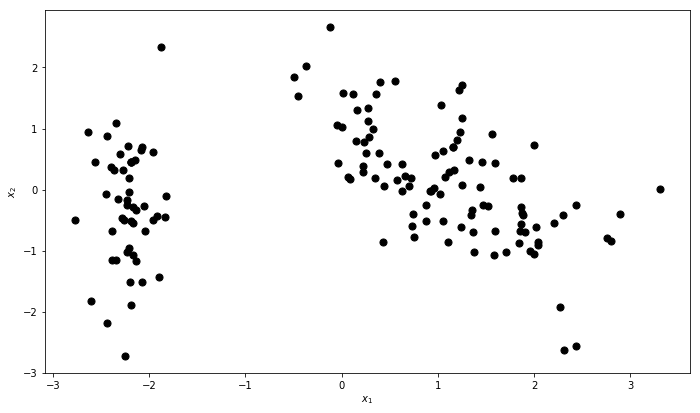

In [19]:
X_pca = pca(X, 2)
fig = plot_unlabeled_data(X_pca)

## 8.3. Metryki

In [20]:
def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

In [44]:
# Wykres danych
def plot_data_for_classification(X, Y, xlabel=None, ylabel=None, Y_predicted=[], highlight=None):
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    X = X.tolist()
    Y = Y.tolist()
    X1n = [x[1] for x, y in zip(X, Y) if y[0] == 0]
    X1p = [x[1] for x, y in zip(X, Y) if y[0] == 1]
    X2n = [x[2] for x, y in zip(X, Y) if y[0] == 0]
    X2p = [x[2] for x, y in zip(X, Y) if y[0] == 1]
    
    if len(Y_predicted) > 0:
        Y_predicted = Y_predicted.tolist()
        X1tn = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 0]
        X1fn = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 0]
        X1tp = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 1]
        X1fp = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 1]
        X2tn = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 0]
        X2fn = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 0]
        X2tp = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 1]
        X2fp = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 1]
    
        if highlight == 'tn':
            ax.scatter(X1tn, X2tn, c='r', marker='x', s=100, label='Dane')
            ax.scatter(X1fn, X2fn, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='k', marker='x', s=50, label='Dane')
        elif highlight == 'fn':
            ax.scatter(X1tn, X2tn, c='k', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='g', marker='o', s=100, label='Dane')
            ax.scatter(X1tp, X2tp, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='k', marker='x', s=50, label='Dane')
        elif highlight == 'tp':
            ax.scatter(X1tn, X2tn, c='k', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='g', marker='o', s=100, label='Dane')
            ax.scatter(X1fp, X2fp, c='k', marker='x', s=50, label='Dane')
        elif highlight == 'fp':
            ax.scatter(X1tn, X2tn, c='k', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='r', marker='x', s=100, label='Dane')
        else:
            ax.scatter(X1tn, X2tn, c='r', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='g', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='g', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='r', marker='x', s=50, label='Dane')

    else:
        ax.scatter(X1n, X2n, c='r', marker='x', s=50, label='Dane')
        ax.scatter(X1p, X2p, c='g', marker='o', s=50, label='Dane')
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    ax.margins(.05, .05)
    return fig

In [45]:
# Wczytanie danych
import pandas
import numpy as np

alldata = pandas.read_csv('data.tsv', sep='\t')
data = np.matrix(alldata)

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 1:]

X2 = powerme(data[:, 1], data[:, 2], n)
Y2 = np.matrix(data[:, 0]).reshape(m, 1)

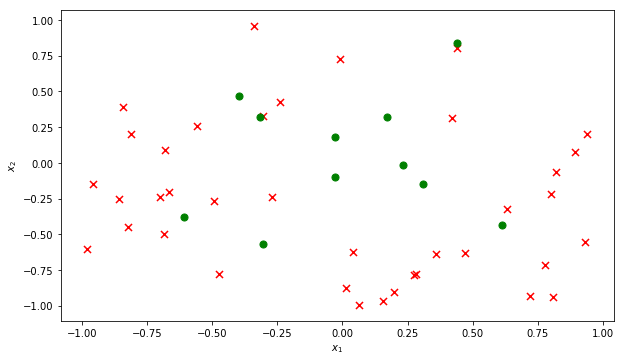

In [46]:
fig = plot_data_for_classification(X2, Y2, xlabel=r'$x_1$', ylabel=r'$x_2$')

In [47]:
def safeSigmoid(x, eps=0):
    y = 1.0/(1.0 + np.exp(-x))
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y, lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m
    if lamb > 0:
        j += lamb/(2*m) * np.sum(np.power(theta[1:],2))
    return j

def dJ(h,theta,X,y,lamb=0):
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    if lamb > 0:
        g[1:] += lamb/float(y.shape[0]) * theta[1:] 
    return g

def classifyBi(theta, X):
    prob = h(theta, X)
    return prob

In [48]:
# Metoda gradientu prostego dla regresji logistycznej
def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

In [49]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
theta_start = np.matrix(np.zeros(X2.shape[1])).reshape(X2.shape[1],1)
theta, errors = GD(h, J, dJ, theta_start, X2, Y2, 
                       alpha=0.1, eps=10**-7, maxSteps=10000)
print('theta = {}'.format(theta))

theta = [[ 1.37136167]
 [ 0.90128948]
 [ 0.54708112]
 [-5.9929264 ]
 [ 2.64435168]
 [-4.27978238]]


In [50]:
# Wykres granicy klas
def plot_decision_boundary(fig, theta, X):
    ax = fig.axes[0]
    xx, yy = np.meshgrid(np.arange(-1.0, 1.0, 0.02),
                         np.arange(-1.0, 1.0, 0.02))
    l = len(xx.ravel())
    C = powerme(xx.reshape(l, 1), yy.reshape(l, 1), n)
    z = classifyBi(theta, C).reshape(int(np.sqrt(l)), int(np.sqrt(l)))

    plt.contour(xx, yy, z, levels=[0.5], lw=3);

In [51]:
Y_predicted = (classifyBi(theta, X2) > 0.5).astype(int)
Y_predicted[:10]

matrix([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0]])

In [52]:
# Przygotowanie interaktywnego wykresu

dropdown_highlight = widgets.Dropdown(options=['all', 'tp', 'fp', 'tn', 'fn'], value='all', description='highlight')

def interactive_classification(highlight):
    fig = plot_data_for_classification(X2, Y2, xlabel=r'$x_1$', ylabel=r'$x_2$',
                                       Y_predicted=Y_predicted, highlight=highlight)
    plot_decision_boundary(fig, theta, X2)

In [53]:
widgets.interact(interactive_classification, highlight=dropdown_highlight)

interactive(children=(Dropdown(description=u'highlight', options=('all', 'tp', 'fp', 'tn', 'fn'), value='all'), Output()), _dom_classes=('widget-interact',))

<function __main__.interactive_classification>

Dokładność (_accuracy_):
$$ accuracy = \frac{tp + tn}{tp + fp + tn + fn} $$

Precyzja (_precision_):
    $$ precision = \frac{tp}{tp + fp} $$

Pokrycie (_recall_):
    $$ recall = \frac{tp}{tp + fn} $$

_$F$-measure_:
$$ F = \frac{2 \cdot precision \cdot recall}{precision + recall} $$

_$F_\beta$-measure_:
$$ F_\beta = \frac{(1 + \beta) \cdot precision \cdot recall}{\beta^2 * precision + recall} $$

* $F = F_1$